<a href="https://colab.research.google.com/github/NikolValerie/homework/blob/main/08_02_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Вторник
## Нейронные сети
### 🔥 PyTorch: Fashion MNIST

В этом задании необходимо классифицировать изображения датасета Fashion MNIST - аналогичного набору рукописных цифр. Для решения этой задачи не нужна сложная нейросеть,

In [36]:
!pip install torchutils

In [37]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torchutils as tu
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120


In [38]:
train_loader = DataLoader(
    FashionMNIST(
        root='data/',
        train=True,
        download=True,
        transform=ToTensor()
    ),
    batch_size=64

)
valid_loader = DataLoader(
    FashionMNIST(
        root='data/',
        train=False,
        download=True,
        transform=ToTensor()
    ),
    batch_size=64
)

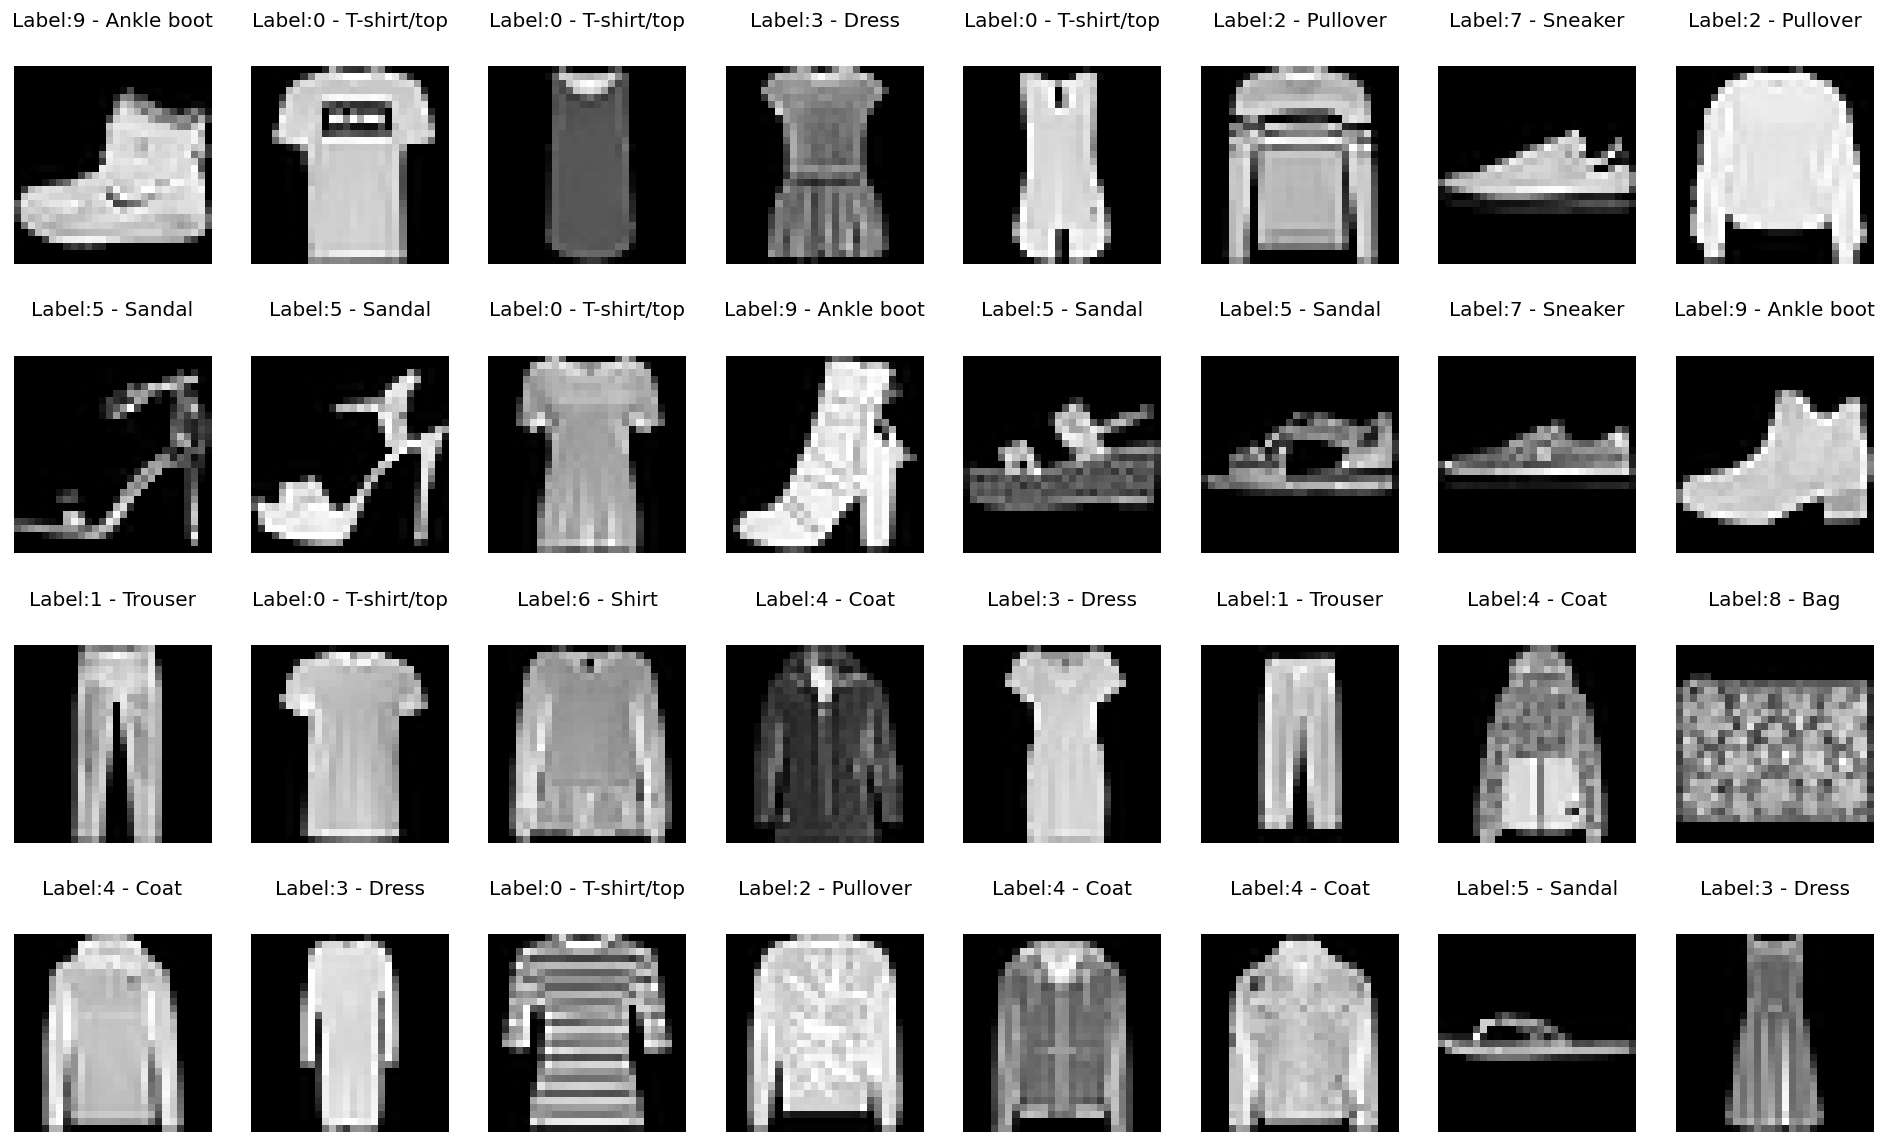

In [39]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels

# распечатаем произвольную картинку
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
batch, labels = get_batch_from_loader(train_loader)
for i, plot in enumerate(ax):
    plot.set_title(f'Label:{labels[i]} - {train_loader.dataset.classes[labels[i]]}')
    plot.matshow(batch[i][0, :, :], cmap='gray')
    plot.axis('off')

In [40]:
train_loader.dataset.classes
train_loader.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

1. Задай класс модели: начни с самого простого однослойного персептрона.

In [58]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()

    plt.show()

In [59]:
BATCH_SIZE=64
DEVICE = 'cpu'

In [61]:
# Задаем класс модели
class MnistTorchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x_first_out = F.relu(self.fc1(x))
        x_second_out = self.dropout(F.relu(self.fc2(x_first_out)))
        x_final = self.fc3(x_second_out)
        return x_final

In [62]:
model = MnistTorchClassifier()
model.to(DEVICE)

MnistTorchClassifier(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

2. С помощью `tu.get_model_summary` распечатай структуру модели

In [63]:
tu.get_model_summary(model, torch.randn(BATCH_SIZE, 28, 28, device=DEVICE))
history = None

Layer        Kernel      Output    Params       FLOPs
0_fc1       [784, 32]   [64, 32]   25,120   3,209,216
1_fc2        [32, 16]   [64, 16]      528      64,512
2_dropout           -   [64, 16]        0           0
3_fc3        [16, 10]   [64, 10]      170      19,840
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
Total FLOPs: 3,293,568 / 3.29 MFLOPs
-----------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.04
Params size (MB): 0.10
Estimated Total Size (MB): 0.33


3. Задай оптимизатор и функцию потерь

In [73]:
history = {'train_accs': [], 'train_losses': [], 'valid_accs': [], 'valid_losses': []}


In [64]:
criterion = nn.CrossEntropyLoss()

def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        history = None
        ) -> dict:

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = []
        for samples, labels in train_loader:

            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        # Validation
        model.eval()

        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    plot_history(history)

    return history

------------- Epoch 1 -------------
train: accuracy 0.5880, loss 1.0581
valid: accuracy 0.7885, loss 0.6038
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.6776, loss 0.8361
valid: accuracy 0.8116, loss 0.5307
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.7026, loss 0.7758
valid: accuracy 0.8162, loss 0.5076
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.7218, loss 0.7304
valid: accuracy 0.8301, loss 0.4863
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.7352, loss 0.7046
valid: accuracy 0.8310, loss 0.4733
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.7432, loss 0.6852
valid: accuracy 0.8381, loss 0.4599
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.7508, loss 0.6616
valid: accuracy 0.8360, loss 0.4530
----------------------

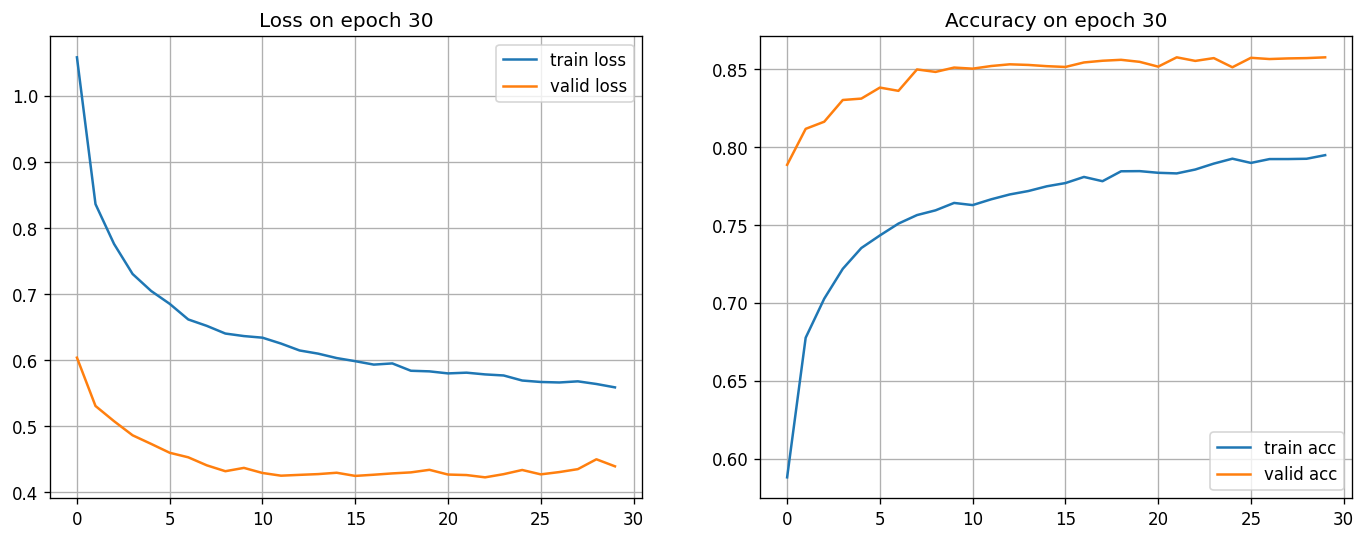

In [65]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=.001)
history = fit_model(model, 30, optimizer=optimizer)

4. Реализуй цикл обучения: функция должна возвращать историю лосса на обучении и валидации, а также значение метрики `accuracy`.

5. Попробуй создать еще 2 модели с разной архитектурой и проанализируй качество ыих решений. Для этого распечатай графики лосса и метрики на выборках. На что повлияло число нейронов и слоев?

❗️ Самые сложные модели должны достигать качества >80% на валидационной части выборки.

------------- Epoch 1 -------------
train: accuracy 0.1338, loss 2.2962
valid: accuracy 0.2019, loss 2.2749
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.1853, loss 2.2582
valid: accuracy 0.2033, loss 2.2355
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.2193, loss 2.2232
valid: accuracy 0.2343, loss 2.1969
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.2395, loss 2.1877
valid: accuracy 0.2842, loss 2.1578
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.2472, loss 2.1564
valid: accuracy 0.3191, loss 2.1196
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.2553, loss 2.1235
valid: accuracy 0.3402, loss 2.0813
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.2629, loss 2.0940
valid: accuracy 0.3566, loss 2.0438
----------------------

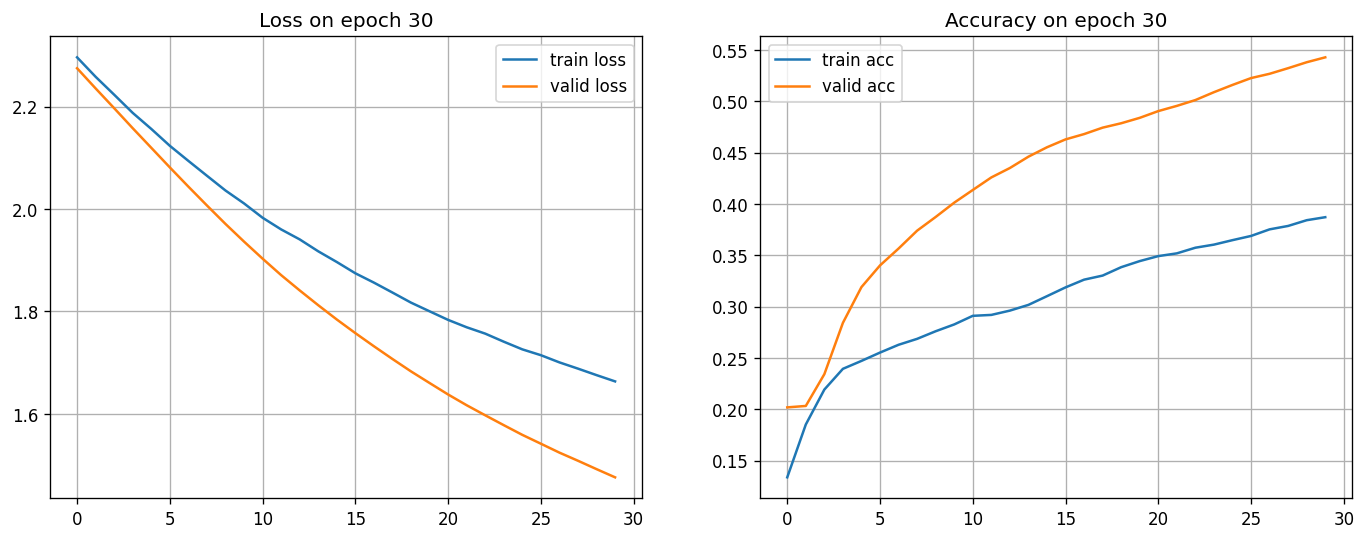

In [68]:
model1 = MnistTorchClassifier()
model1.to(DEVICE)

optimizer1 = torch.optim.Adadelta(model1.parameters(), lr=.001)
history1 = fit_model(model1, 30, optimizer=optimizer1)

------------- Epoch 1 -------------
train: accuracy 0.1805, loss 2.2867
valid: accuracy 0.3421, loss 2.2541
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.2205, loss 2.2166
valid: accuracy 0.3114, loss 2.1564
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.2366, loss 2.1087
valid: accuracy 0.3634, loss 2.0003
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.2665, loss 1.9703
valid: accuracy 0.4143, loss 1.8230
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.3035, loss 1.8358
valid: accuracy 0.4770, loss 1.6518
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.3423, loss 1.7152
valid: accuracy 0.5117, loss 1.5008
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.3706, loss 1.6153
valid: accuracy 0.5806, loss 1.3814
----------------------

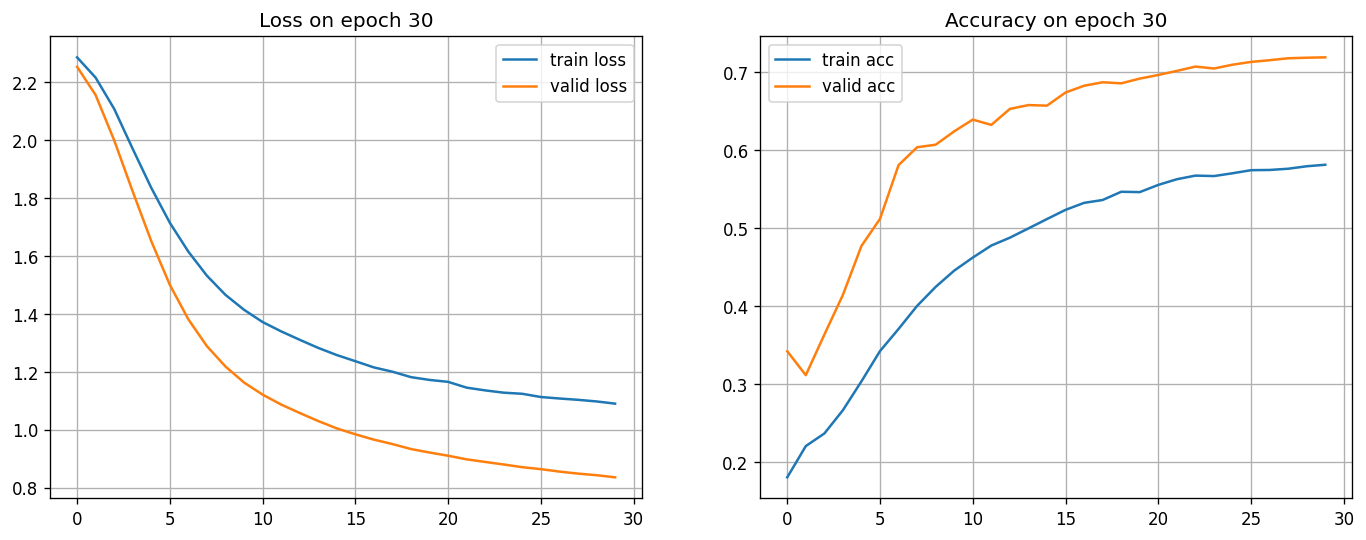

In [69]:
model2 = MnistTorchClassifier()
model2.to(DEVICE)

optimizer2 = torch.optim.SGD(model2.parameters(), lr=.001)
history2 = fit_model(model2, 30, optimizer=optimizer2)

------------- Epoch 1 -------------
train: accuracy 0.3196, loss 1.8324
valid: accuracy 0.5029, loss 1.5199
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.3973, loss 1.6010
valid: accuracy 0.5545, loss 1.3579
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.4360, loss 1.4968
valid: accuracy 0.6243, loss 1.2529
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.4614, loss 1.4248
valid: accuracy 0.6543, loss 1.1810
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.4776, loss 1.3778
valid: accuracy 0.6756, loss 1.1285
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.4910, loss 1.3457
valid: accuracy 0.6912, loss 1.0864
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.5084, loss 1.3077
valid: accuracy 0.7020, loss 1.0512
----------------------

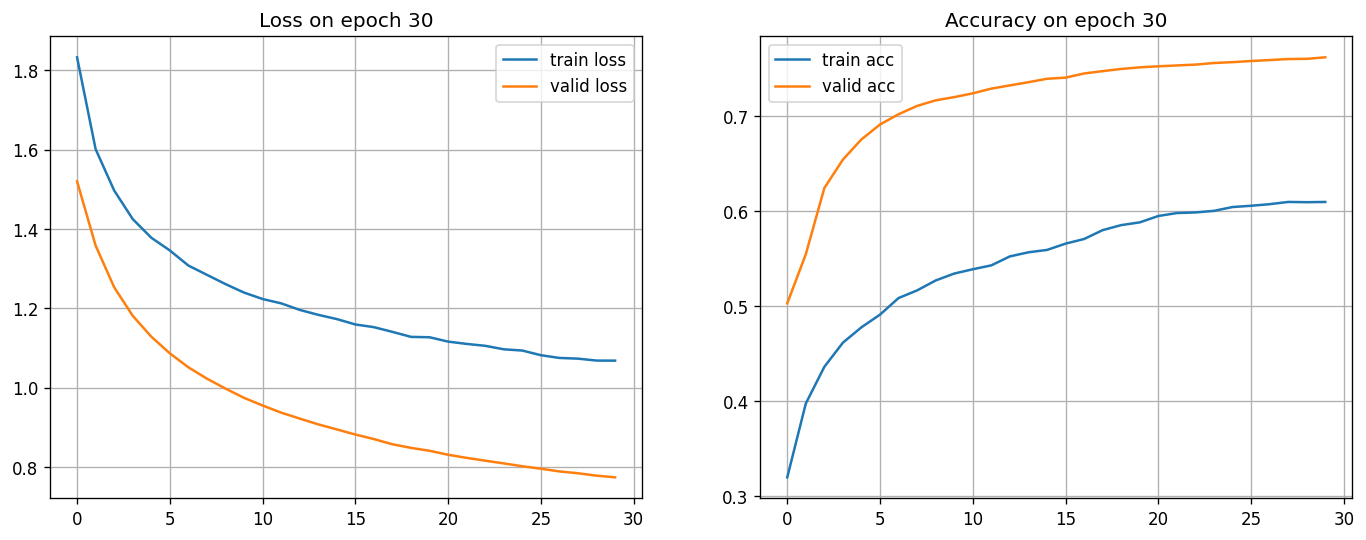

In [70]:
model3 = MnistTorchClassifier()
model3.to(DEVICE)

optimizer3 = torch.optim.Adagrad(model3.parameters(), lr=.001)
history3 = fit_model(model3, 30, optimizer=optimizer3)

# ❓

Для чего при обучении применяется слой `Dropout`?

> ответ тут

6. Обучи лучшую модель 3 раза с тремя разными оптимизаторами: `SGD`, `Adagrad`, `Adadelta`. Визуализируй график лосса и сравни, как изменяется значение функции потерь в зависимости от используемого алгоритма оптимизации. Какой алгоритм самый лучший?

В результате должен получиться **примерно** такой график:

![](aux/imgs/08-02-res.png)

<ipython-input-79-fb6f9bf20aeb>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


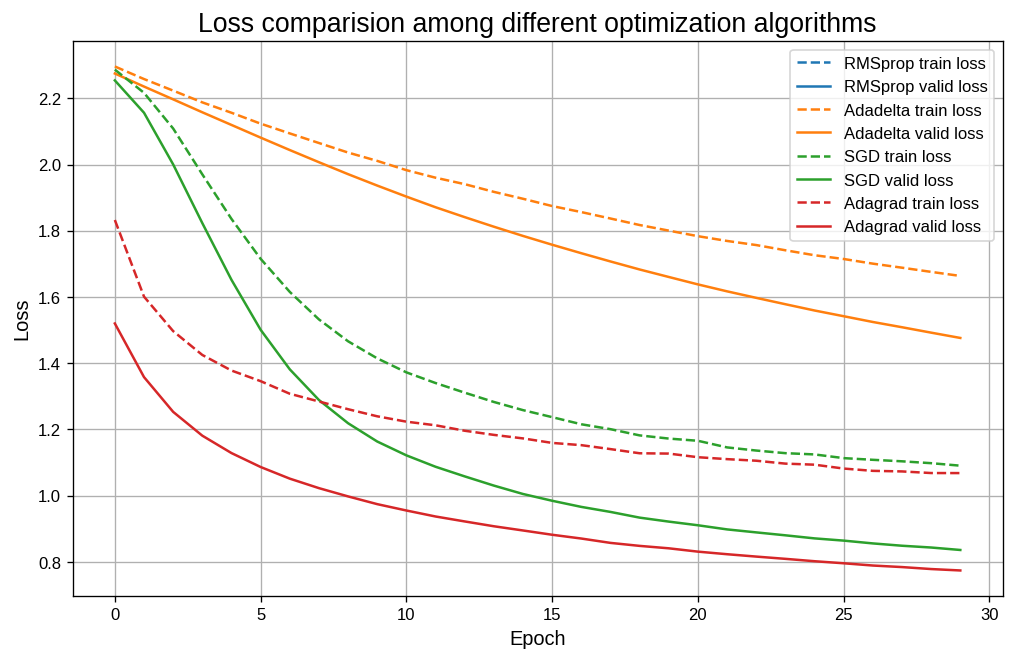

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history['train_losses'], label='RMSprop train loss', linestyle='--', color='tab:blue')
ax.plot(history['valid_losses'], label='RMSprop valid loss', color='tab:blue')

ax.plot(history1['train_losses'], label='Adadelta train loss', linestyle='--', color='tab:orange')
ax.plot(history1['valid_losses'], label='Adadelta valid loss', color='tab:orange')

ax.plot(history2['train_losses'], label='SGD train loss', linestyle='--', color='tab:green')
ax.plot(history2['valid_losses'], label='SGD valid loss', color='tab:green')

ax.plot(history3['train_losses'], label='Adagrad train loss', linestyle='--', color='tab:red')
ax.plot(history3['valid_losses'], label='Adagrad valid loss', color='tab:red')

ax.set_title('Loss comparision among different optimization algorithms', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True)
ax.legend()
plt.style.use('seaborn-dark')
plt.show()


### 🎓 Реализуй архитектуру, представленную ниже, и сравни ее эффективность с обученными выше моделями.
Такое можно сделать только с помощью разработки класса модели, обычный sequential-подход тут не поможет.


<img src="aux/imgs/simple_skip_con.png" height=500>